## Completion of Occlusion
This code has been designed for problem statement 3 of Adobe Gensolve hackathon: completion of occluded figures.

The test cases provided for this statement are:


*   occlusion1.csv
*   occlusion2.csv



Install Libraries

In [ ]:
pip install opencv-python numpy scikit-learn matplotlib scipy svgwrite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.0 MB/s eta 0:00:00


Import the libraries required.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from itertools import combinations
import svgwrite


**Clustering shapes**

Shapes are extracted from the combined set of polylines using DBSCAN clustering. This allows to distinguish collection of shapes that are together e.g. a line inside a circle from the ones that are far apart e.g. a rectanle and a star with some distance in between.

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that identifies clusters based on the density of data points. It works by marking points as core points if they have a minimum number of neighboring points within a specified radius (ε). Clusters are formed by connecting core points and their neighbors, while points that do not meet the density criteria are considered noise. DBSCAN can discover clusters of arbitrary shape, does not require specifying the number of clusters beforehand, and is effective at handling noise and outliers in the data.


After the points are clustered, the paths containing those points are extracted from the polylines. Every cluster can be considered as a single shape.








In [ ]:
def read_csv(csv_path):
    """
    Read CSV for the given points (provided from GenSolve)
    Args:
      csv_path: path of the csv file to be read
    Returns:
      paths: dictionary of polyline representing paths and subpaths
    """
    data = np.genfromtxt(csv_path, delimiter=',')
    paths = {}
    for row in data:
        path_id, sub_path_id, x, y = row
        if path_id not in paths:
            paths[path_id] = {}
        if sub_path_id not in paths[path_id]:
            paths[path_id][sub_path_id] = []
        paths[path_id][sub_path_id].append((x, y))
    return paths


def dict_to_numpy_combined(polylines):
    """
    Only for clustering. Convert all the points into a single numpy array for clustering using DBscan
    Returns: [(x1, y1),(x2, y2)]
    """
    path_XYs = []
    for path_id in sorted(polylines.keys()):
        sub_paths = []
        for sub_path_id in sorted(polylines[path_id].keys()):
            XY = np.array(polylines[path_id][sub_path_id])
            if XY.shape[1] >= 2:
                sub_paths.append(XY)
            else:
                print(f"Skipped malformed data: {XY}")
        path_XYs.extend(sub_paths)  # Flatten into a single list of arrays
    return np.vstack(path_XYs)  # Combine all arrays into one


def extract_clusters(polylineNDArray):
    """
    Extract point clusters (shapes) from the polylines using DBscan
    """
    # Step 3: Apply DBSCAN clustering
    db = DBSCAN(eps=7, min_samples=10).fit(polylineNDArray)                       # create DBSCAN clustering object and fit to X
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)       # create a boolean mask with the same size as the labels array filled with zeros to identify core samples later
    core_samples_mask[db.core_sample_indices_] = True               # sets the elements of the core_samples_mask corresponding to core samples
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    clustered_data = []

    # Step 4: Visualization
    unique_labels = set(labels)
    # firstly assign a plotcolor value to each unique label as a dictionary
    # for k, col in zip(unique_labels, plotcolors):
    for k in unique_labels:
        # creates a mask that selects points beloging to the current cluster k
        class_member_mask = (labels == k)
        # core_samples_mask is a boolean array indicating the points which beling to the current cluster k
        # performs element-wise logical AND between the two masks, meaning only the points belonging to both
        # the current cluster and the core samples are selected
        # resulting data points are assigned to xy
        xy = polylineNDArray[class_member_mask & core_samples_mask]
        clustered_data.append([k, xy])

    print(f"Number of clusters detected: {n_clusters_}")
    return clustered_data


def clusters_from_polylines(polyline_np_array, clusters):
    """
    Extract the clusters from the given polylines.
    Args:
        polyline_np_array: numpy array of polylines
        clusters: list of detected clusters
    Returns:
        extracted_clusters = [[[(x1, y1), (x2, y2)]]]
    """
    # first create a list for the clusters to be extracted
    extracted_clusters = []
    added_paths = set()

    for _, cluster_data in enumerate(clusters):
        cluster_id, cluster_points = cluster_data
        # skip including for the noise cluster
        if cluster_id == -1:
            continue
        extracted_clusters.append([])
        # we put the entire path into the cluster in this case
        for path_index, path in enumerate(polyline_np_array):
            # skip paths that have already been added to a cluster
            if path_index in added_paths:
                if len(extracted_clusters[-1]) == 0:
                    extracted_clusters.pop()    # remove the last appended empty array for nothing is there to insert in this iteration
                continue
            path_added = False              # flag to indicate if the path was added as an extracted cluster

            # if a point in the path exists in the cluster, put the entire path into the cluster
            # and move on to the next path
            for subpath_idex, subpath in enumerate(path):
                for point_index, point in enumerate(subpath):
                    if np.any(np.all(point == cluster_points, axis=1)):
                        print(f"included path{path_index} in cluster: {cluster_id}")
                        extracted_clusters[cluster_id].append(path)
                        added_paths.add(path_index)
                        path_added = True
                        break
                if path_added:
                    break
    return extracted_clusters


def dict_to_numpyarray(polylines):
    """
    convert the polyline dictionary into a numpy array containg all the paths and subpaths
    """
    path_XYs = []           # init empty list to store the formatted paths
    # iterate over each path_id in the dictionary, sorted by the path_id
    for path_id in sorted(polylines.keys()):
        sub_paths = []      # init empty list to store the sub-paths for the current path_id
        # iterate over each sub_path id in the current path_id, sorted by the sub_path_id
        for sub_path_id in sorted(polylines[path_id].keys()):
            # convert the list of (x,y) tuples into a NumPy array
            XY = np.array(polylines[path_id][sub_path_id])
            # check if the array has atleast two columns (x and y)
            if XY.shape[1] >= 2:
                # if valid, append the numpy array to the sub_paths list
                sub_paths.append(XY)
            else:
                print(f"Skipped malformed data: {XY}")
        path_XYs.append(sub_paths)
    return path_XYs

**Detecting overlaps and extracting occluded path**

Overlaps are detected inside a cluster by checking if within a cluster, a point of a particular path is very close (lesser than a threshold) to another point in a different path or subpath within the same cluster.

The path with the maximum overlapping points is the occluded path that is to be completed, because it has overlapping points with all the different paths occlude it. The occluded path is extracted for completion

In [ ]:
def get_overlap_points(cluster, threshold=1, min_distance_between_overlaps=1):
    """
    Check whether a point in any path or subpath within the same cluster overlaps or is very close to another point in a different path or subpath within the same cluster.
    Args:
        cluster: A cluster containing paths and subpaths
        threshold: Distance threshold below which points are considered overlapping
        min_distance_between_overlaps: distance between checked points below which they are considered overlapping
    Returns:
        overlaps: List of dictionaries indicating overlapping points with their paths and subpaths in the same cluster
    """
    overlaps = []
    checked_combinations = set()    # keeping track of checked path comboinations
    for path_index_1, path_1 in enumerate(cluster):
        for subpath_index_1, subpath_1 in enumerate(path_1):
            for point_index_1, point_1 in enumerate(subpath_1):
                # for this point check for overlapping points in other paths
                for path_index_2, path_2 in enumerate(cluster):
                    # skip consecutive paths and already checked combinations
                    if (path_index_1, path_index_2) in checked_combinations:
                        continue
                    for subpath_index_2, subpath_2 in enumerate(path_2):
                        # avoid considering the point in the same subpath of the same path
                        if path_index_1 == path_index_2 and subpath_index_1 == subpath_index_2:
                            continue    # skip checking within the same subpath
                        for point_index_2, point_2 in enumerate(subpath_2):
                            # check comes here
                            distance = np.linalg.norm(point_1 - point_2)
                            # distance less than threshold means the points are overlapping
                            if distance <= threshold:
                                # mid point can be considered as the actual overlapping point
                                too_close = False
                                for existing_overlap in overlaps:
                                    existing_point_1 = existing_overlap["point_1"]
                                    existing_point_2 = existing_overlap["point_2"]
                                    if (np.linalg.norm(point_1 - existing_point_1) < min_distance_between_overlaps or
                                        np.linalg.norm(point_1 - existing_point_2) < min_distance_between_overlaps or
                                        np.linalg.norm(point_2 - existing_point_1) < min_distance_between_overlaps or
                                        np.linalg.norm(point_2 - existing_point_2) < min_distance_between_overlaps):
                                        too_close = True
                                        break
                                if not too_close:
                                    mid_point = (point_1 + point_2) / 2
                                    overlaps.append({
                                        "point_1": point_1,
                                        "path_index_1": path_index_1,
                                        "subpath_index_1": subpath_index_1,
                                        "point_index_1": point_index_1,
                                        "point_2": point_2,
                                        "path_index_2": path_index_2,
                                        "subpath_index_2": subpath_index_2,
                                        "point_index_2": point_index_2,
                                        "distance": distance,
                                        "mid_point": mid_point
                                    })
                                # mark this combination of paths as checked
                                checked_combinations.add((path_index_1, path_index_2))
    return overlaps


def get_overlap_paths(overlaps, min_count=1):
    """
    Extract the path that has the maximum intersection point in the figure.
    Args:
        overlaps: List of dictionaries containing info about the overlaps.
        min_count: Minimum number of occurrences for a path to be extracted.
    Returns:
        max_overlap_path: Path index that has the maximum number of overlapping points.
    """
    # Dictionary to count occurrences of each path index
    path_count = {}
    # Count occurrences of each path index
    for overlap in overlaps:
        path_index_1 = overlap['path_index_1']
        path_index_2 = overlap['path_index_2']
        # Increment the count for both paths
        if path_index_1 in path_count:
            path_count[path_index_1] += 1
        else:
            path_count[path_index_1] = 1
        if path_index_2 in path_count:
            path_count[path_index_2] += 1
        else:
            path_count[path_index_2] = 1
    # Find the path with the maximum count
    max_overlap_path = max(path_count, key=path_count.get, default=None)
    # Ensure the path has more than `min_count` occurrences
    # print(path_count)
    if path_count.get(max_overlap_path, 0) >= min_count:
        return max_overlap_path
    else:
        return None


def visualize_overlaps(path_dict, overlaps):
    """
    Visualize the overlapping points in the cluster
    Args:
        path_dict: dictionary of the polylines
        overlaps: list of dictionaries of overlapping points
    """
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Add more colors if needed
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    fig.suptitle("Point overlaps")
    # Plot polylines
    for path_id, sub_paths in path_dict.items():
        color = colours[int(path_id) % len(colours)]
        for sub_path_id, points in sub_paths.items():
            points = np.array(points)
            ax.plot(points[:, 0], points[:, 1], c=color, linewidth=2, label=f"Path {path_id}-{sub_path_id}")

    # Plot points with different markers based on cluster_id
    cluster_markers = ['o', 's', '^', 'P', 'D', 'v', 'h']
    for overlap_id, overlap in enumerate(overlaps):
        marker = cluster_markers[overlap_id % len(cluster_markers)]
        x, y = overlap["mid_point"]  # Assuming point_1 key holds the point coordinates
        ax.plot(x, y, marker=marker, markersize=8, color='black', linestyle='None', label=f"point {overlap_id}")
    ax.set_aspect('equal')
    ax.legend()
    plt.show()


def extract_occluded_paths(cluster):
    """
    Separate the occluded paths from the given clusters
    Args:
        clusters: clusters from where to extract the paths
    Returns:
        extrtacted_polylines: extracted polylines
        remaining_polylines: remaining polylines
        overlap_path_index: the extracted path index
    """
    extracted_paths = []
    remaining_paths = []
    # sort the indices to ensure correct deletion order

    overlap_path_indices = [
        get_overlap_paths(
        get_overlap_points(cluster, threshold=10, min_distance_between_overlaps=1))
        ]
    overlap_path_indices = sorted(overlap_path_indices)

    for i, path in enumerate(cluster):
        if i in overlap_path_indices:
            extracted_paths.append(path)
        else:
            remaining_paths.append(path)
    return extracted_paths, remaining_paths, overlap_path_indices[0]


def midpoints_from_overlaps(overlaps):
    """
    Extract the midpoint for the overlapping points.
    Args:
        overlaps: List of object from the overlap detection function
    Returns:
        overlap_points: List of tuples of the midpoint overlaps
    """
    overlap_points = []
    for overlap_id, overlap in enumerate(overlaps):
        overlap_points.append(overlap["mid_point"])
    return overlap_points


**Plotting functions**

In [ ]:
plotcolors = [
    "#FF0000",  # Red
    "#00FF00",  # Green
    "#0000FF",  # Blue
    "#FFFF00",  # Yellow
    "#800080",  # Purple
    "#FF7F00",  # Orange
    "#FFC0CB",  # Pink
    "#A52A2A",  # Brown
    "#808080",  # Gray
    "#008080",  # Teal
    "#E6E6FA",  # Lavender
    "#808000",  # Olive
    "#800000",  # Maroon
    "#000080",  # Navy
    "#40E0D0",  # Turquoise
    "#FF7F50",  # Coral
    "#00FF7F",  # Spring Green
    "#FFD700",  # Gold
    "#C0C0C0",  # Silver
    "#FF00FF",  # Magenta
    "#8B0000",  # Dark Red
    "#2E8B57",  # Sea Green
    "#DAA520",  # Goldenrod
    "#4B0082",  # Indigo
    "#00CED1",  # Dark Turquoise
    "#9400D3",  # Dark Violet
    "#FF1493",  # Deep Pink
    "#708090",  # Slate Gray
    "#8B4513",  # Saddle Brown
    "#556B2F",  # Dark Olive Green
    "#6A5ACD",  # Slate Blue
    "#4682B4",  # Steel Blue
    "#FF6347",  # Tomato
    "#7FFF00",  # Chartreuse
    "#D2691E"   # Chocolate
]

def plot_paths_numpy(paths, figname="plot"):
    """
    Plot polylines from NumPy array of polylines
    Args:
        paths: NumPy array of paths
    """
    fig, ax = plt.subplots(tight_layout=True, figsize=(8,8))
    if figname is not None:
        fig.suptitle(figname)

    for path_id, path in enumerate(paths):
        color = plotcolors[int(path_id) % len(plotcolors)]
        for sub_path_id, subpath in enumerate(path):
            ax.plot(subpath[:, 0], subpath[:, 1], c=color, linewidth=2)
    ax.set_aspect('equal')
    plt.show()



def image_from_numpyarray(path_XYs):
    """
    Deprecated: Create a single channel edge image for the given formatted polyline numpy array
    """
    # Determine the size of the image
    max_x = int(np.max([np.max(XY[:, 0]) for XYs in path_XYs for XY in XYs if XY.shape[1] >= 2]))
    max_y = int(np.max([np.max(XY[:, 1]) for XYs in path_XYs for XY in XYs if XY.shape[1] >= 2]))
    # Create a blank image
    image = np.zeros((max_y + 10, max_x + 10, 3), dtype=np.uint8)
    # Draw the shapes on the image
    for XYs in path_XYs:
        for XY in XYs:
            points = np.array([(x, y) for x, y in XY], np.int32)
            points = points.reshape((-1, 1, 2))
            cv.polylines(image, [points], isClosed=False, color=255, thickness=1)
    return image


def visualize_clusters(clusterlist):
    """
    plot the list of clusters extracted using DBscan
    """
    num_clusters = len(clusterlist)
    # zip the labels with the colors
    for k, color in zip(clusterlist, plotcolors):
        label, cluster_points = k
        # remove the noise from the count of the number of clusters
        if label == -1:
            num_clusters -= 1
            color = "black"     # black color is used for the noise
        plt.plot(cluster_points[:, 0], cluster_points[:, 1], 'o', markerfacecolor=color,
            markeredgecolor='k',
            markersize=6)

    plt.title(f'Number of clusters: {num_clusters}')
    plt.show()


**Filtering the occluded path**

The extracted occluded path contains irregular shapes at the point of occlusion. The point of occlusion is the area of the occluded path where it was occluded by the other paths. It has maximum overlapping points in that area. The irregular shapes at the point of occlusion are noises, and thus need to be removed. For this, the occluded path polyline is converted into an image, but a rectangular strip of area containing the overlapping points at the area of occlusion are removed/skipped while creating the image from the polyline.

This filters the irregularities so that shape detection can be applied afterwards.


In [ ]:
def img_from_numpy_rectangleskip(path_XYs, skip_points, rect_width=25, rect_height=80):
    """
    Create the original image from numpy array and skip drawing a rectangular area around specified points.
    Args:
        path_XYs: A list of numpy arrays representing paths.
        skip_points: A list of points (x, y) where drawing should be skipped.
        rect_width: The width of the rectangular area to skip.
        rect_height: The height of the rectangular area to skip.

    Returns:
        image: An image with the paths drawn on it, except for the skipped areas.
    """
    # Determine the size of the image
    max_x = int(np.max([np.max(XY[:, 0]) for XYs in path_XYs for XY in XYs if XY.shape[1] >= 2]))
    max_y = int(np.max([np.max(XY[:, 1]) for XYs in path_XYs for XY in XYs if XY.shape[1] >= 2]))
    # Create a blank image
    image = np.zeros((max_y + 10, max_x + 10, 3), dtype=np.uint8)

    # Draw the shapes on the image
    for XYs in path_XYs:
        for XY in XYs:
            for i in range(len(XY) - 1):
                point_1 = XY[i]
                point_2 = XY[i + 1]

                # Skip drawing the line if it is within the rectangular region of any skip_point
                skip_line = False
                for skip_point in skip_points:
                    x_min = skip_point[0] - rect_width // 2
                    x_max = skip_point[0] + rect_width // 2
                    y_min = skip_point[1] - rect_height // 2
                    y_max = skip_point[1] + rect_height // 2
                    if (x_min <= point_1[0] <= x_max and y_min <= point_1[1] <= y_max) or \
                       (x_min <= point_2[0] <= x_max and y_min <= point_2[1] <= y_max):
                        skip_line = True
                        break

                if not skip_line:
                    points = np.array([(point_1[0], point_1[1]),
                                       (point_2[0], point_2[1])], np.int32)
                    points = points.reshape((-1, 1, 2))
                    cv.polylines(image, [points], isClosed=False, color=255, thickness=1)

    return image

**Detector Functions**

For the fileterd occluded path, a sequence of detector funtions is applied for appropriate shape detection. More detector functions can be applied in sequence for detecting a diverse set of shapes.

**Ellipse detection:**
It detects ellipses in an image by first converting the image to grayscale and then detecting contours. For each contour with a sufficient number of points, it fits an ellipse.

The best-fitting ellipse is calculated using the Direct Least Squares (DLS) fitting method. This involves calculating the centroid of the contour points and then computing the covariance matrix of these points. Eigenvalue decomposition is performed on the covariance matrix to determine the orientation and lengths of the ellipse's axes. From the eigenvalues and eigenvectors, the function derives the ellipse's center, the lengths of the major and minor axes, and the rotation angle, ensuring the ellipse best represents the distribution of the contour points.

In [ ]:
def detect_ellipse(image, min_length=200):
    """
    Detects an ellipse in the provided image.
    Argv:
        image: provided image
        min_length: min no of points to fit an ellipse
    Returns:
        ellipses: list of detected ellipses
        result: image containing the detected ellipses
    """
    ellipses = []
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    contours, hierarchy = cv.findContours(gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)  # find contours in the binary image
    print(f"{len(contours)} contours found")
    result = image.copy()   # copy of the original imae to draw the ellipses
    for contour in contours:
        # fit an ellipse to the contour if there are enough points
        if len(contour) >= min_length:
            ellipse = cv.fitEllipse(contour)
            cv.ellipse(result, ellipse, (0, 0, 255), 2)
            ellipses.append(ellipse)
    return ellipses, result

def ellipses_to_polylines(ellipses, delta=1):
    """
    Converts the detected ellipses into a polyline format.
    Args:
        ellipses: List of detected ellipses from the detect_ellipse function.
        delta: Angle step size for sampling points on the ellipse (1 to 180).
    Returns:
        paths: List of paths, where each path corresponds to an ellipse.
    """
    paths = []
    for ellipse in ellipses:
        (center, axes, angle) = ellipse
        # Convert ellipse parameters to integers for cv2.ellipse2Poly
        center = (int(center[0]), int(center[1]))
        axes = (int(axes[0] / 2), int(axes[1] / 2))
        angle = int(angle)
        # Ensure delta is within the valid range
        delta = max(1, min(180, delta))
        print(f"delta={delta}")
        # Generate points along the ellipse using cv2.ellipse2Poly
        points = cv.ellipse2Poly(center, axes, angle, 0, 360, delta)
        # Convert the points to the desired format and append as a subpath
        subpath = np.array(points)
        paths.append([subpath])
    return paths


**Circle detection**

Circles are identified within a set of polylines using the Hough Circle Transform. First, it converts the polylines into an image and then to grayscale. The grayscale image is blurred to reduce noise, making circle detection more accurate. The Hough Circle Transform is then applied, which works by identifying circular shapes based on the gradient information in the image. It returns the parameters (center coordinates and radius) of detected circles.

In [ ]:
def detect_circle2(polylines):
    """
    Detect circles in the given polylines using Hough Circle Transform
    Args:
        polylines: polyline path representing the semi ciruclar path
    Returns:
        detected_circles = circle parameters a, b, r in integer format
    """
    img = image_from_numpyarray(polylines)
    height, width, channels = img.shape
    width = int(width)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Blur using 3 * 3 kernel.
    gray_blurred = cv.blur(gray, (3, 3))
    # Apply Hough transform on the blurred image.
    detected_circles = cv.HoughCircles(gray_blurred,
                    cv.HOUGH_GRADIENT, 1.5, 20, param1 = 50,
                param2 = 40, minRadius = int(width/2.5 + 10), maxRadius = int(width/1.3))
    # Draw circles that are detected.
    if detected_circles is not None:
        # Convert the circle parameters a, b and r to integers.
        detected_circles = np.uint16(np.around(detected_circles))
        return detected_circles
    else:
        return None


def hough_transform_circle_fit_individual(paths):
    """
    Accepts individual paths and checks each for the best fitting circle using Hough Transform.
    Args:
        paths: A list of paths to be checked.
    Returns:
       best_path: The path that forms the best circle.
       best_circle_params: Parameters of the best detected circle.
    """
    best_path = None
    best_circle_params = None
    # Iterate over each path individually
    for pathid, path in enumerate(paths):
        # Convert the single path into a format suitable for Hough Transform
        detected_circles = detect_circle2([path])  # Passing the path as a list to keep the format consistent
        if detected_circles is not None:
            # Update the best circle parameters and the corresponding path
            best_path = path
            best_circle_params = detected_circles
            print("circle detected")
            break  # Return as soon as a valid circle is found
    return best_path, best_circle_params  # Return the best path and circle parameters, or None if no circle was found


def draw_detected_circle2(detected_circles):
    # Determine the size of the image based on the detected circles
    max_x = int(np.max(detected_circles[0, :, 0]) + np.max(detected_circles[0, :, 2])) + 10
    max_y = int(np.max(detected_circles[0, :, 1]) + np.max(detected_circles[0, :, 2])) + 10
    # Create a blank image where the circle will be drawn
    img = np.zeros((max_y, max_x, 3), dtype=np.uint8)
    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]
        # Draw the circumference of the circle.
        cv.circle(img, (a, b), r, (0, 255, 0), 2)
        # Draw a small circle (of radius 1) to show the center.
        cv.circle(img, (a, b), 1, (0, 0, 255), 3)
        cv.imshow("Detected Circle", img)
        cv.waitKey(0)


def circles_to_polyline(detected_circles, num_points=10000):
    """
    Converts detected circles into a polyline format with paths and subpaths.
    Args:
        detected_circles: Detected circles from Hough Transform, in the format [x, y, radius].
        num_points: Number of points to approximate the circle. Higher numbers give a smoother polyline.
    Returns:
        polylines: A list of paths, where each path corresponds to a detected circle.
    """
    polylines = []
    for circle in detected_circles[0, :]:
        a, b, r = circle[0], circle[1], circle[2]
        subpath = []
        for i in range(num_points):
            theta = np.deg2rad(i * 360 / num_points)
            x = int(a + r * np.cos(theta))
            y = int(b + r * np.sin(theta))
            subpath.append((x, y))
        subpath = np.array(subpath)
        polylines.append([subpath])
    return polylines

**File upload**

The test cases provided for problem statement 3: completion of occluded figures are:


*   occlusion1.csv
*   occlusion2.csv



Load the csv file for occlusion into the NoteBoook and define the path here

In [ ]:
csv_file = read_csv('/content/occlusion2.csv')

**Main function**
Reading and visualzing clusters

Number of clusters detected: 1


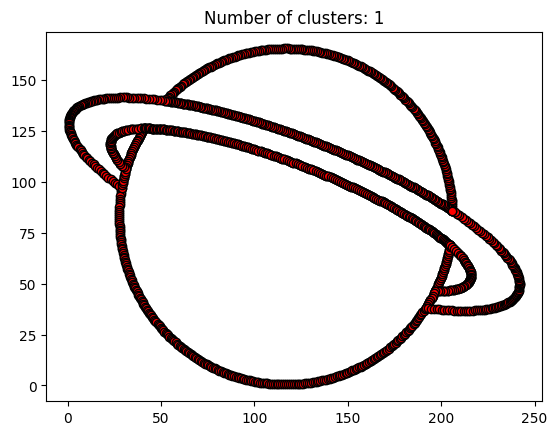

clusters detected: 1
included path0 in cluster: 0
included path1 in cluster: 0
included path2 in cluster: 0
included path3 in cluster: 0
included path4 in cluster: 0


In [ ]:
# combined numpy array is required for the clustering
points_numpy_combined = dict_to_numpy_combined(csv_file)
clusters = extract_clusters(points_numpy_combined)
visualize_clusters(clusters)
print("clusters detected:", len(clusters))
# polyline format numpy array is required for all the detector functions for converting into image
polylines_numpy = dict_to_numpyarray(csv_file)
clustered_polylines = clusters_from_polylines(polylines_numpy, clusters)

In [ ]:
n

Looping through the clusters extracting occluded paths, filtering, shape detection in the occluded paths and the remaining paths of the polylines.

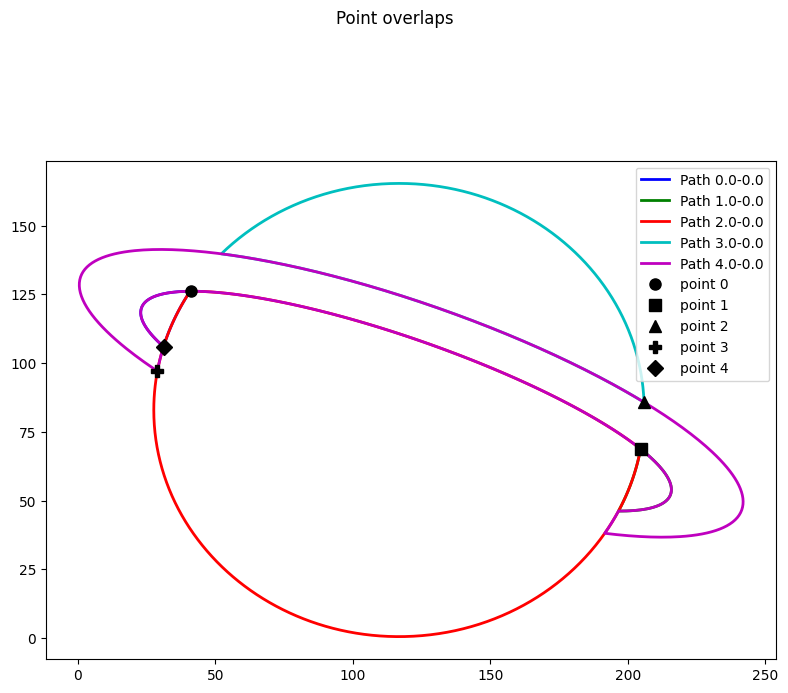

overlaps detected: 5
5 contours found
delta=1
delta=1


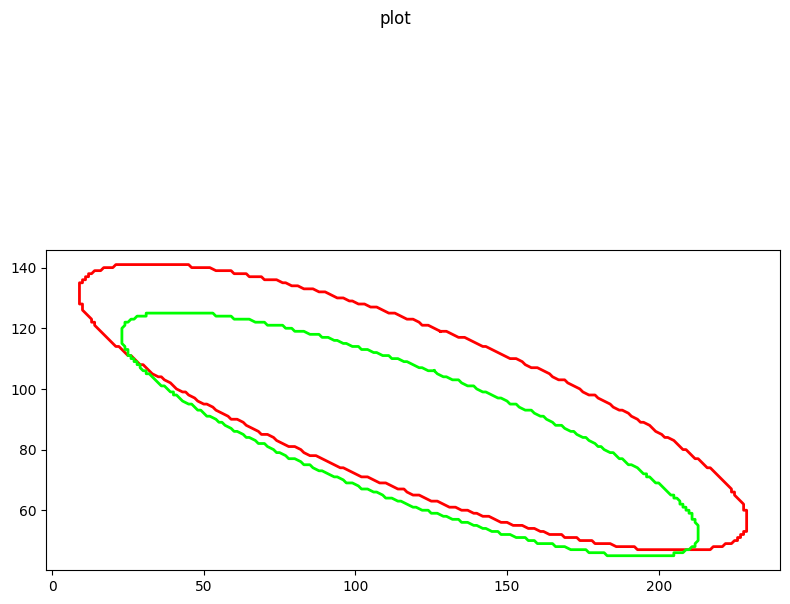

circle detected


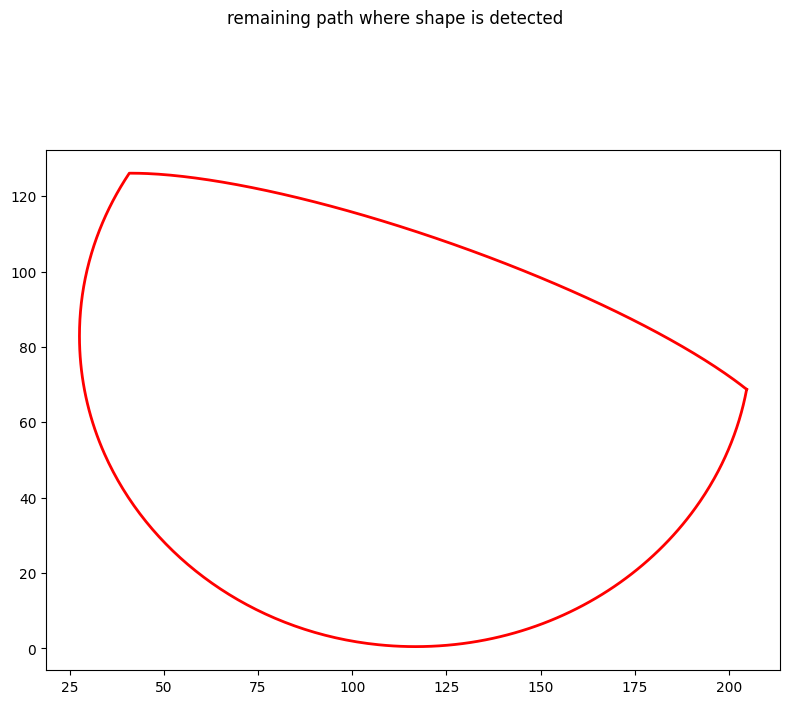

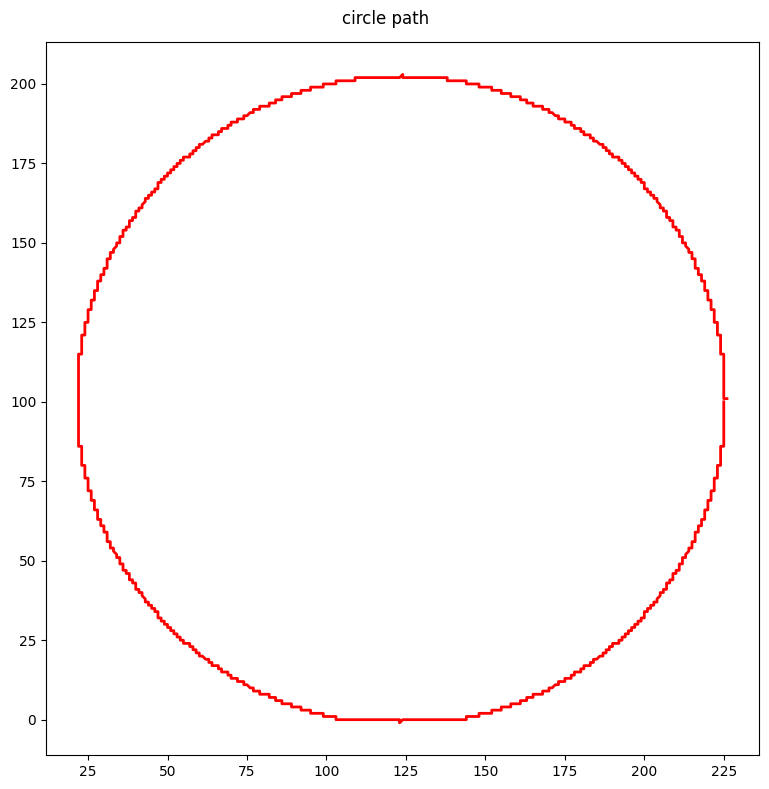

In [ ]:
completed_shapes = []
# occlusion detecion and removal for every cluster detected
for _, cluster in enumerate(clustered_polylines):
    overlap_points = get_overlap_points(cluster)
    # comment-out to avoid overlap visualization
    visualize_overlaps(csv_file, overlap_points)
    print(f"overlaps detected: {len(overlap_points)}")
    occluded_paths, remaining_paths, occluded_path_index = extract_occluded_paths(cluster)
    # completing the shapes now
    # detecting shapes in occlusion
    overlap_midpoints = midpoints_from_overlaps(overlap_points)
    occluded_image = img_from_numpy_rectangleskip(occluded_paths, overlap_midpoints)
    # cv.imshow("occluded image", occluded_image)
    # shape detection at this point
    detected_ellipses, ellipse_image = detect_ellipse(occluded_image)
    if detected_ellipses is not None:
        # cv.imshow("detected ellipse", ellipse_image)
        filled_occlusion = ellipses_to_polylines(detected_ellipses)
        completed_shapes.extend(filled_occlusion)
    plot_paths_numpy(filled_occlusion)            # drawing the filled occlusion
    # detecting and filling the remaining paths now
    best_paths, circle_params = hough_transform_circle_fit_individual(remaining_paths)
    if circle_params is not None:
        plot_paths_numpy([best_paths], "remaining path where shape is detected")
        # cr.draw_detected_circle2(circle_params)
        circle_paths = circles_to_polyline(circle_params)
        plot_paths_numpy(circle_paths, "circle path")
        completed_shapes.extend(circle_paths)
    # else if no detected shapes are found we simply add the remaining paths to the completed occlusion
    else:
        completed_shapes.extend(remaining_paths)

Finally plotting the completed figure

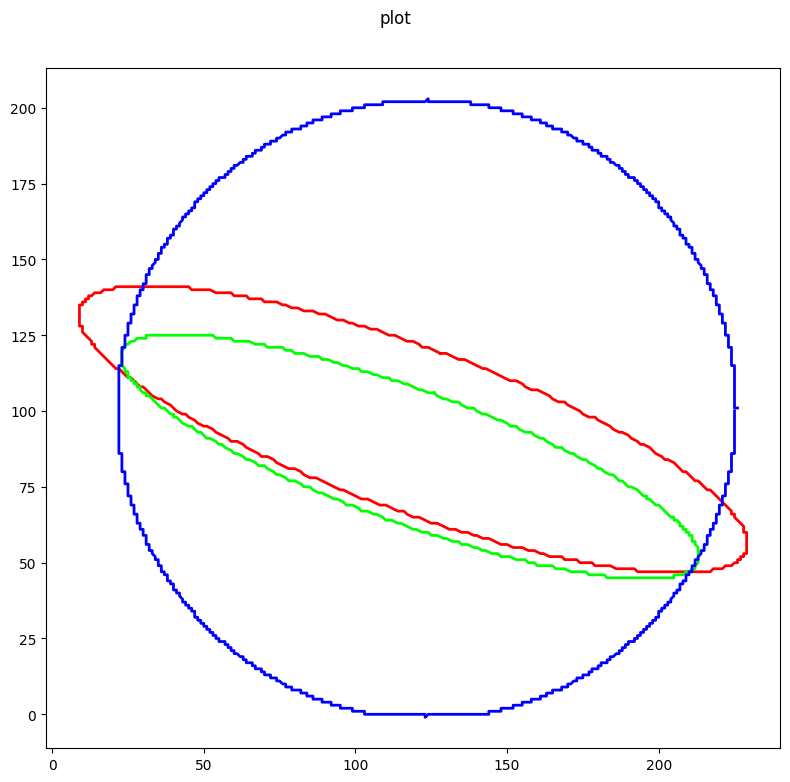

In [ ]:
plot_paths_numpy(completed_shapes)

Converting the polylines back to SVG format

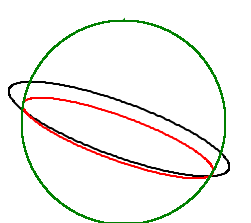

In [ ]:
from IPython.display import SVG, display

def polylines_to_svg(paths_XYs, svg_path):
    """
    Converts a list of polylines (paths_XYs) to an SVG image and saves it.
    Args:
        paths_XYs (list): List of numpy arrays, where each array represents a polyline with coordinates.
        svg_path (str): Path to save the SVG image.
    """
    # Calculate the bounding box of the image
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W = max(W, np.max(XY[:, 0]))
            H = max(H, np.max(XY[:, 1]))

    padding = 0.1
    W = int(W + padding * W)
    H = int(H + padding * H)

    # Create a new SVG drawing
    dwg = svgwrite.Drawing(svg_path, size=(W, H), profile='tiny')

    colours = ['black', 'red', 'green', 'blue', 'yellow', 'cyan', 'magenta']  # Add more colors if needed

    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            # Adjust the Y-coordinate to prevent mirroring
            adjusted_XY = XY.copy()
            adjusted_XY[:, 1] = H - adjusted_XY[:, 1]
            # Move to the first point
            path_data.append(("M", (adjusted_XY[0, 0], adjusted_XY[0, 1])))
            # Draw lines to the subsequent points
            for j in range(1, len(adjusted_XY)):
                path_data.append(("L", (adjusted_XY[j, 0], adjusted_XY[j, 1])))
        # Convert path data to string format suitable for SVG
        path_str = " ".join(f"{cmd}{x},{y}" for cmd, (x, y) in path_data)
        # Add the path to the SVG drawing
        dwg.add(dwg.path(d=path_str, fill='none', stroke=c, stroke_width=2))

    # Save the SVG file
    dwg.save()

    # Finally display the file in the notebook
    display(SVG(svg_path))


polylines_to_svg(completed_shapes, '/content/completed_occlusion.svg')